In [1]:
import torch
import argparse
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from utils import generate_trainset, standardize_data, leave_one_out_crossval, plot_scatter
from GP_models import MTGPR

/home/zlh/micromamba/envs/mat/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_PATH = './data/dataset.csv'
ADD_OUTPUTS = ['Voc', 'Jsc', 'FF', 'D_V0', 'D_J0', 'contact_angle', 'PLQY_perov', 'PLQY_glass', 't1_perov', 't2_perov', 't1_glass', 't2_glass']
features = ["C count", "N count", "O count", "H count", "S count",
            "F count", "Cl count", "atoms count", "atoms in ring",
            "aromatic atoms count", "bonds count", "conjugated bonds count",
            "aromatic bonds count", "rotatable bonds count", "carbonyl O (excl. COOH) count",
            "exact molecular weight", "Morgan FP density", "fraction of SP3 C", "log P",
            "molar refractivity", "has tertiary amine", "has secondary amine", "has imine",
            "has thiophene", "has pyrrole", "has benzimidazole", "has benzothiophene",
            "has naphthalene", "has biphenyl", "dipole", "homo level", "lumo level",
            "homo/lumo gap", "total energy", "rotation constant a", "rotation constant b",
            "rotation constant c", 'purity']

print('Generating trainset...')
X, y, samples_composition = generate_trainset(path=DATA_PATH, use_simulation=True, objective='PCE', add_labels=ADD_OUTPUTS)


Generating trainset...
INFO: Reading excel files.
INFO: Reading structures.


100%|██████████| 149/149 [00:00<00:00, 343.59it/s]


INFO: Making features:


100%|██████████| 149/149 [00:01<00:00, 144.72it/s]


In [6]:
### ELIMINATE FEATURES THAT HAVE A SINGLE VALUES (constant) OR VERY NARROW DISTRIBUTIONS (spiked) ON THE TRAIN SET
####spiked = ['F', "O", 'S', "fr_C_O_noCOO", "has_Benzimidazole", "has_Benzothiophene", "has_Naphthalene", "has_Thiophene"]
####constant = ['Cl', "has_C=NC", "has_CNC", "has_Pyrrole"]
SPIKED = [5, 2, 4, 14, 25, 26, 27, 23]
CONSTANT = [6, 21, 22, 24]
NOT_GOOD = sorted(CONSTANT+SPIKED)
MASK_FEATURES = np.ones(X.shape[-1], dtype=bool)
MASK_FEATURES[NOT_GOOD] = False
X = X[..., MASK_FEATURES]

task_labels = [
    'PCE', '$V_{oc}$', '$J_{sc}$', 'FF', '$D_{V_{0}}$', '$D_{J_{0}}$', 'CA',
    '$PLQY_{perov}$', '$PLQY_{glass}$', '$t1_{perov}$', '$t2_{perov}$',
    '$t1_{glass}$', '$t2_{glass}$',
]

xtrain, ytrain, _, _ = standardize_data(X, y)
regr = MTGPR(xtrain, ytrain)
regr.fit()

In [8]:
B = regr.model.covar_module.task_covar_module.covar_factor.detach().numpy()
v = regr.model.covar_module.task_covar_module.var.detach().numpy()
task_covar = np.matmul(B,B.T) + np.diag(v)

[[1.52832782e+00 1.18150222e+00 1.58401310e+00 1.38724577e+00
  4.58012134e-01 1.31988609e+00 9.02311318e-03 2.36489967e-01
  3.70018005e-01 3.22538279e-02 3.78166556e-01 1.11644715e-01
  4.10646081e-01]
 [1.18150222e+00 1.13798058e+00 1.22786045e+00 1.07533467e+00
  3.55031788e-01 1.02312028e+00 6.99433824e-03 1.83317095e-01
  2.86822438e-01 2.50018127e-02 2.93138832e-01 8.65422934e-02
  3.18315595e-01]
 [1.58401310e+00 1.22786045e+00 1.71329534e+00 1.44167674e+00
  4.75983024e-01 1.37167406e+00 9.37714987e-03 2.45769054e-01
  3.84536296e-01 3.35193612e-02 3.93004566e-01 1.16025284e-01
  4.26758498e-01]
 [1.38724577e+00 1.07533467e+00 1.44167674e+00 1.33817434e+00
  4.16856050e-01 1.20128369e+00 8.21231306e-03 2.15239435e-01
  3.36768925e-01 2.93555614e-02 3.44185233e-01 1.01612538e-01
  3.73746216e-01]
 [4.58012134e-01 3.55031788e-01 4.75983024e-01 4.16856050e-01
  5.41594386e-01 3.96615028e-01 2.71137198e-03 7.10633099e-02
  1.11187398e-01 9.69201326e-03 1.13635965e-01 3.35483290e-0

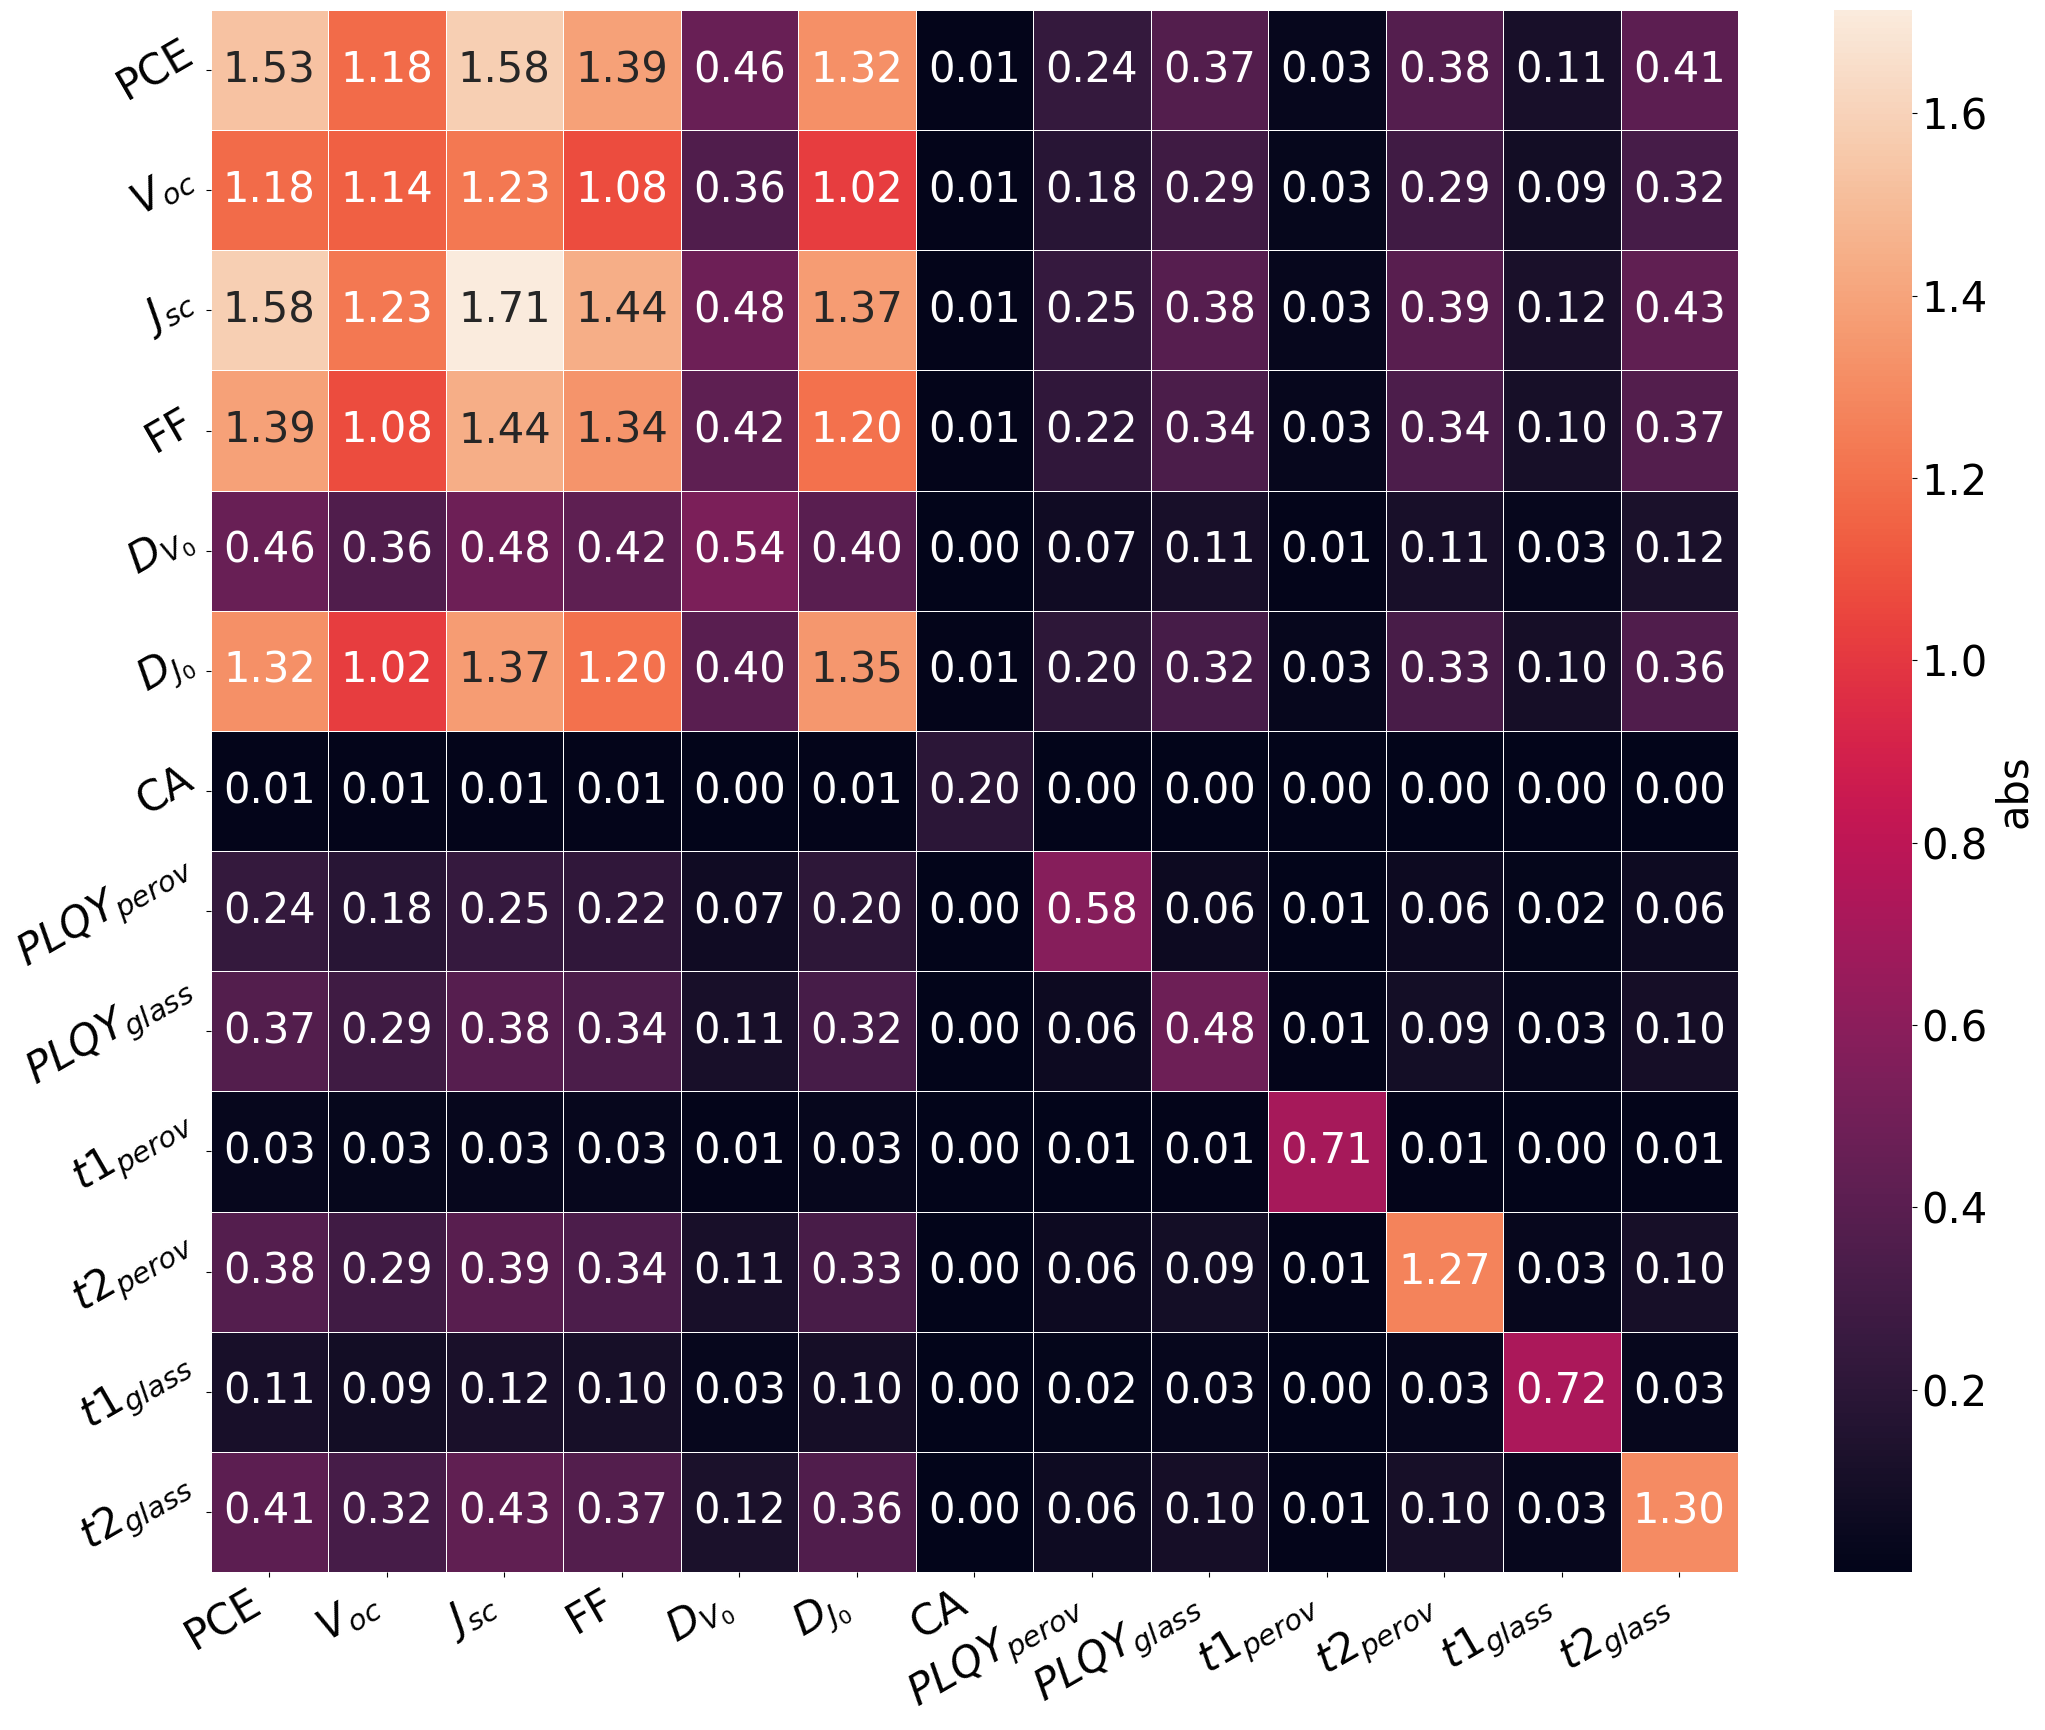

In [9]:
plt.figure(figsize = (22,18))
plt.rcParams['font.size'] = 30

print(np.abs(task_covar))
ax = sns.heatmap(
    np.abs(task_covar),
    linewidth=0.5,
    annot=True,
    fmt=".2f",
    xticklabels=task_labels,
    yticklabels=task_labels,
    cbar_kws={'label':'abs'},
    )
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.setp(ax.get_yticklabels(), rotation=30, horizontalalignment='right')
plt.tight_layout()
plt.show()
# plt.close()